## Authored by:
* Faten Racha SAID - M2 DAC
* Mounir MAOUCHE - M2 IMA




In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2024-12-22 13:54:53--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2024-12-22 13:54:53--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.005s  

2024-12-22 13:54:53 (6.77 MB/s) - ‘imagenet_classes.pkl’ saved [35454

In [ ]:
vgg16 = torchvision.models.vgg16(weights=True)
vgg16.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 166MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

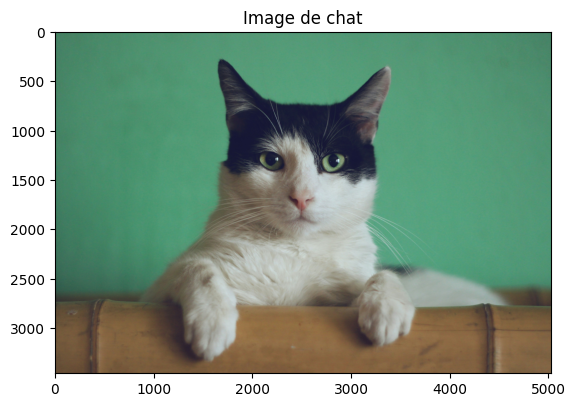

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 94.6MB/s]


Output shape: torch.Size([1, 1000])


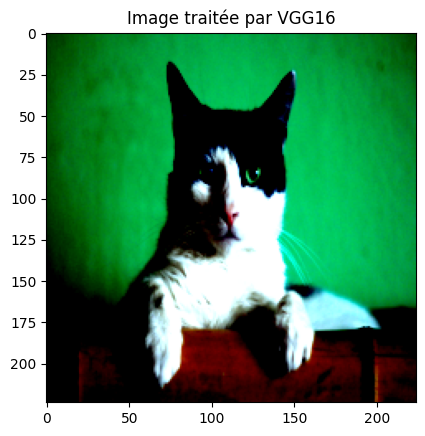

Predicted class: Egyptian cat


In [ ]:
nameim = "cat" + ".jpg"
#cat = Image.open('cat.jpg')
img = Image.open(nameim)
plt.imshow(img)
plt.title("Image de chat")
plt.show()


# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))
vgg16 = torchvision.models.vgg16(weights=True)

def vgg16_predict(img, imagenet_classes, vgg16 ):
  # Convert image to RGB if it has an alpha channel
  img = img.convert('RGB')  # Ensure image is in RGB format (removes alpha if present)


  # Normalization
  img = img.resize((224, 224), Image.BILINEAR)
  img = np.array(img, dtype=np.float32) / 255
  img = img.transpose((2, 0, 1))
  # Convert img to PyTorch Tensor
  img = torch.tensor(img)
  # ImageNet mean/std
  mu = torch.Tensor([0.485, 0.456, 0.406])
  sigma = torch.Tensor([0.229, 0.224, 0.225])
  # Expand mu & sigma to match image size
  # Shape final : (3, 1, 1) pour broadcast avec une image 3 x H x W. Equivalent à unsqueeze().unsqueeze()
  mu = mu[:, None, None]
  sigma = sigma[:, None, None]
  # Compute the normalized image with ImageNet mean image
  img = (img - mu) / sigma

  # Loading pre-trained VGG
  vgg16.eval()  # WHY THAT? (see report)

  # Forward pass on VGG
  img = np.expand_dims(img, 0)
  x = torch.Tensor(img)

  with torch.no_grad():
      y = vgg16(x)  # TODO: forward pass calculation

  print("Output shape:", y.shape)

  # Get prediction (i.e., ImageNet class label)
  # Retrieve the class with the highest score
  _, predicted_class = torch.max(y, 1)

  # Display the result
  predicted_class_name = imagenet_classes[predicted_class.item()]
  plt.imshow(np.array(img.squeeze(0).transpose(1, 2, 0)))  # Revert preprocessing to display the image
  plt.title("Image traitée par VGG16")
  plt.show()
  return predicted_class_name

predicted_class_name= vgg16_predict(img, imagenet_classes, vgg16 )
print(f"Predicted class: {predicted_class_name}")



### Test on more images

Output shape: torch.Size([1, 1000])
Predicted class: wire-haired fox terrier


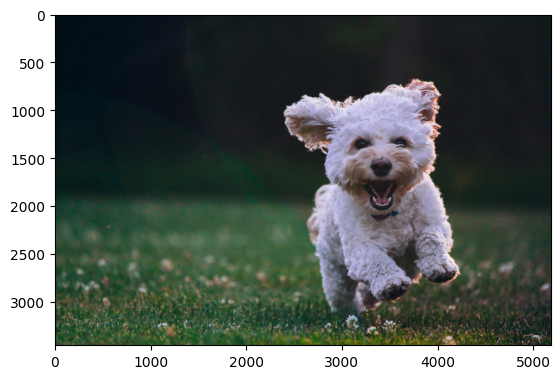

In [ ]:
nameim = "dog" + ".jpg"
img = Image.open(nameim)
plt.imshow(img)
predicted_class_name= vgg16_predict(img, imagenet_classes, vgg16 )
print(f"Predicted class: {predicted_class_name}")

Output shape: torch.Size([1, 1000])
Predicted class: pill bottle


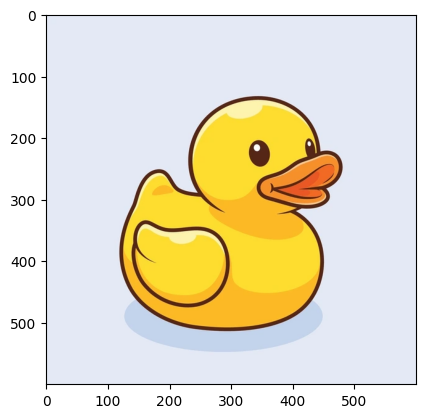

In [ ]:
nameim = "img_tme1/cartoon-duck.jpg"
img = Image.open(nameim)
plt.imshow(img)
predicted_class_name= vgg16_predict(img, imagenet_classes, vgg16 )
print(f"Predicted class: {predicted_class_name}")

Output shape: torch.Size([1, 1000])
Predicted class: toilet seat


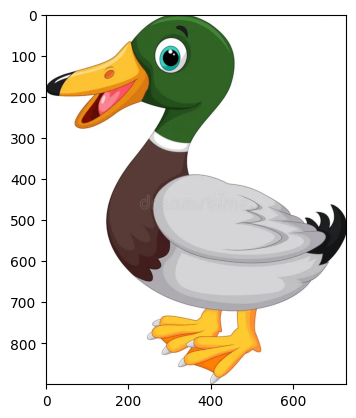

In [ ]:
nameim = "img_tme1/duck.jpg"
img = Image.open(nameim)
plt.imshow(img)
predicted_class_name= vgg16_predict(img, imagenet_classes, vgg16 )
print(f"Predicted class: {predicted_class_name}")

Output shape: torch.Size([1, 1000])
Predicted class: drake


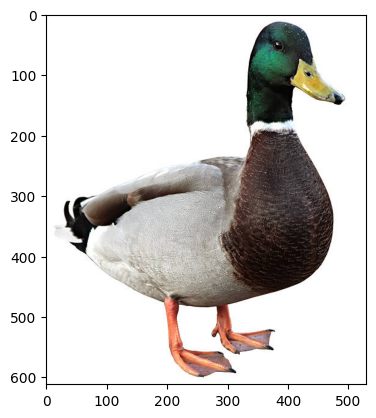

In [ ]:
nameim = "img_tme1/duck_real.jpg"
img = Image.open(nameim)
plt.imshow(img)
predicted_class_name= vgg16_predict(img, imagenet_classes, vgg16 )
print(f"Predicted class: {predicted_class_name}")

Output shape: torch.Size([1, 1000])
Predicted class: bolo tie, bolo, bola tie, bola


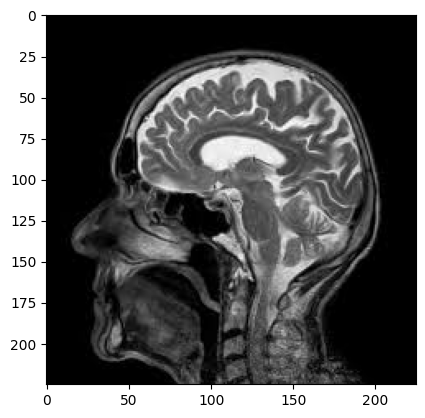

In [ ]:
nameim = "img_tme1/brain.jpg"
img = Image.open(nameim)
plt.imshow(img)
predicted_class_name= vgg16_predict(img, imagenet_classes, vgg16 )
print(f"Predicted class: {predicted_class_name}")

Output shape: torch.Size([1, 1000])
Predicted class: bolo tie, bolo, bola tie, bola


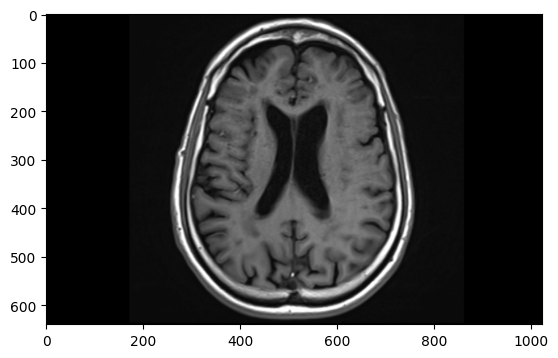

In [ ]:
nameim = "img_tme1/brain_2.png"
img = Image.open(nameim)
plt.imshow(img)
predicted_class_name= vgg16_predict(img, imagenet_classes, vgg16 )
print(f"Predicted class: {predicted_class_name}")

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2024-12-22 13:55:00--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2024-12-22 13:55:00--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   294MB/s    in 0.3s    

2024-12-22 13:55:00 (294 MB/s) - ‘15ScenesData.zip’ saved [86520868/86520868]

In [ ]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0035.jpg  image_0068.jpg  image_0103.jpg  image_0141.jpg  image_0182.jpg
image_0004.jpg  image_0037.jpg  image_0069.jpg  image_0104.jpg  image_0142.jpg  image_0189.jpg
image_0006.jpg  image_0039.jpg  image_0071.jpg  image_0112.jpg  image_0144.jpg  image_0190.jpg
image_0007.jpg  image_0040.jpg  image_0073.jpg  image_0113.jpg  image_0148.jpg  image_0191.jpg
image_0008.jpg  image_0042.jpg  image_0074.jpg  image_0114.jpg  image_0150.jpg  image_0192.jpg
image_0011.jpg  image_0043.jpg  image_0077.jpg  image_0115.jpg  image_0152.jpg  image_0195.jpg
image_0013.jpg  image_0047.jpg  image_0080.jpg  image_0117.jpg  image_0153.jpg  image_0196.jpg
image_0014.jpg  image_0049.jpg  image_0081.jpg  image_0118.jpg  image_0156.jpg  image_0200.jpg
image_0016.jpg  image_0050.jpg  image_0082.jpg  image_0119.jpg  image_0157.jpg  image_0202.jpg
image_0017.jpg  image_0052.jpg  image_0084.jpg  image_0120.jpg  image_0158.jpg  image_0203.jpg
image_0018.jpg  image_0053.jpg  image_0086.jpg  im

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self, vgg16):
    super(VGG16relu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))
    # Keep a piece of the classifier:-2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

In [ ]:
PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # This function expands 3 times a gray level image
    # to transform it into an image RGB. Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)
    global mu, sigma
    # Add pre-processing
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pre-processing TODO: duplicateChannel(), resizeImage(), toTensor(), Normalize ()
             transforms.Lambda(duplicateChannel),
             transforms.Lambda(resizeImage),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pre-processing TODO
            transforms.Lambda(resizeImage),                    # Redimensionnement
            transforms.ToTensor(),               # Conversion en tenseur
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],      # Normalisation
                std=[0.229, 0.224, 0.225])
        ]))


    train_loader = DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model):
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # init features matrices
    X = []
    y = []
    ####################
    ##      END        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))

        if CUDA:
            input = input.cuda()
        #####################
        ## YOUR CODE HERE  ##
        #####################
        extracted_features = model(input)

        #Normaliser par la norme L2
        norm = torch.norm(extracted_features, p=2, dim=1, keepdim=True)
        if CUDA:
            norm = norm.cuda()
        extracted_features = extracted_features / norm

        X.append(extracted_features.cpu().detach())
        y.append(target)
        ####################
        ##      END        #
        ####################

    X = torch.cat(X, dim=0)
    y = torch.cat(y, dim=0)
    return X, y


def main(model, path="15SceneData", batch_size=8):
    print('Instanciation de VGG16relu7')
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = model(vgg16)
    ####################
    ##      END        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    X_train = X_train.cpu().numpy()
    y_train = y_train.cpu().numpy()
    X_test = X_test.cpu().numpy()
    y_test = y_test.cpu().numpy()

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0
    SVC = LinearSVC(C=1.0)
    SVC.fit(X_train, y_train)
    accuracy = SVC.score(X_test, y_test)
    ####################
    ##      FIN        #
    ####################
    print('Accuracy = %f' % accuracy)
    return SVC, X_train, y_train, X_test, y_test, accuracy


In [ ]:
svc, *data, accuracy = main(VGG16relu7(vgg16), "15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.888107


# Going Further

Change the layer at which the features are extracted. What is the importance of the depth of this
layer? What is the representation size and what does this change?

In [ ]:
class VGG16FeatureMap(nn.Module):
  def __init__(self, num_layer, nb_dims_input_classif=None, classif=False):
    super(VGG16FeatureMap, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children())[:num_layer])
    # Keep a piece of the classifier:-2 to stop at relu7
    self.classif = classif
    if self.classif and nb_dims_input_classif is not None:
        self.classifier = nn.Sequential(nn.Linear(nb_dims_input_classif, 1000), nn.ReLU())

  def forward(self, x):
    x = self.features(x)
    if self.classif:
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
    return x

In [ ]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Visualisation de feature maps

In [ ]:
path="15SceneData"
batch_size=8
model=VGG16FeatureMap(1)
model = model.cuda()
train, test = get_dataset(batch_size, path)
# Extraction des features
print('Feature extraction')
X_train, y_train = extract_features(train, model)

Feature extraction
Batch 000/188


In [ ]:
X_train.shape

torch.Size([8, 64, 224, 224])

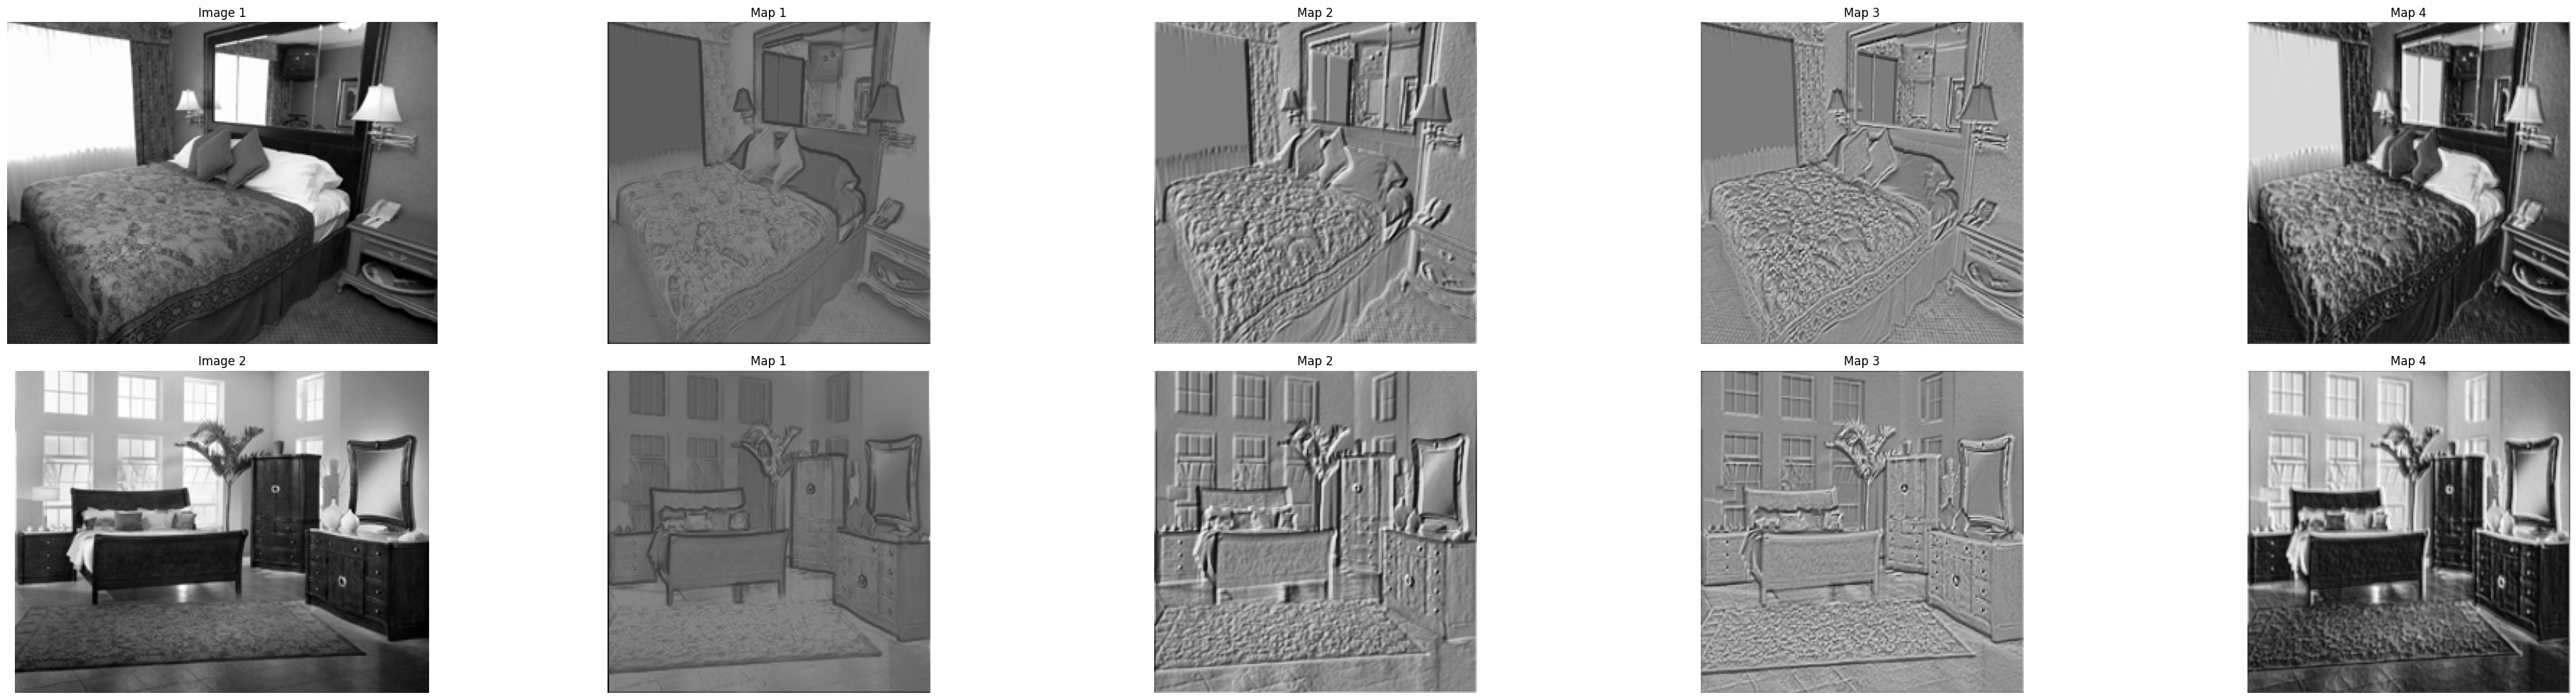

In [ ]:
imgs_ori = [PIL.Image.open("/content/15SceneData/train/bedroom/image_0001.jpg"), PIL.Image.open('/content/15SceneData/train/bedroom/image_0002.jpg')]
example_idx = 0

# Sélectionner quelques cartes d'activation (par exemple, les 6 premières)
num_maps_to_display = 4
num_examples = 2

#selected_maps = activations_example[:num_maps_to_display]  # Taille : [6, 224, 224]
# Afficher les cartes d'activation
fig, axes = plt.subplots(num_examples, num_maps_to_display+1, figsize=(40, 10))
for i, ax in enumerate(axes):
    activations_example = X_train[i]
    selected_maps = activations_example[:num_maps_to_display]
    images_to_display = [imgs_ori[i]] + list(selected_maps.cpu().detach().numpy())

    for j, cell in enumerate(ax):
        cell.imshow(images_to_display[j], cmap='gray')  # Carte d'activation j
        cell.axis('off')
        if j==0:
            cell.set_title(f"Image {i + 1}")
        else:
            cell.set_title(f"Map {j}")
plt.tight_layout()
plt.show()


- La première activation map ressemble au gradient de l'image
- La quatrième ressemble à une augmentation de contrast/saturation

## Extraction de features à une couche différente

In [ ]:
class VGG16FeatureMap(nn.Module):
  def __init__(self, num_layer, channels_in_classif, size_kernel_classif):
    super(VGG16FeatureMap, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children())[:num_layer])
    # Keep a piece of the classifier:-2 to stop at relu7
    #self.classifier = nn.Conv2d(channels_in_classif, 1000, (size_kernel_classif, size_kernel_classif))

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    classifier = nn.Linear(x.size(1), 1000) # not very orthodox but I tried
    classifier = classifier.cuda()
    x = classifier(x)
    return x

In [ ]:
path="15SceneData"
batch_size=8
model=VGG16FeatureMap(11,256, 56)
model = model.cuda()
train, test = get_dataset(batch_size, path)
# Extraction des features
print('Feature extraction')
X_train, y_train = extract_features(train, model)
#X_train, y_train = extract_features(test, model)

Feature extraction
Batch 000/188


KeyboardInterrupt: 

In [ ]:
X_train.shape

torch.Size([1500, 256, 56, 56])

In [ ]:
vgg16 = models.vgg16(pretrained=True)
svc2, *data, accuracy2 = main(VGG16FeatureMap(11, nb_dims_input_classif=128*256*3*3), "15SceneData", 8)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16
Instanciation de VGG16relu7


TypeError: conv2d() received an invalid combination of arguments - got (VGG, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!VGG!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!VGG!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


## Tuning the parameter C of SVM

In [ ]:
model = VGG16relu7(vgg16)
path = "15SceneData"
batch_size = 8

model.eval()
if CUDA: # si on fait du GPU, passage en CUDA
    cudnn.benchmark = True
    model = model.cuda()

# On récupère les données
print('Récupération des données')
train, test = get_dataset(batch_size, path)

# Extraction des features
print('Feature extraction')
X_train, y_train = extract_features(train, model)
X_test, y_test = extract_features(test, model)

#####################
## Votre code ici  ##
#####################
X_train = X_train.cpu().numpy()
y_train = y_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_test = y_test.cpu().numpy()


Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

ConvergenceWarning déclenché pour C = 100
C optimal: 1


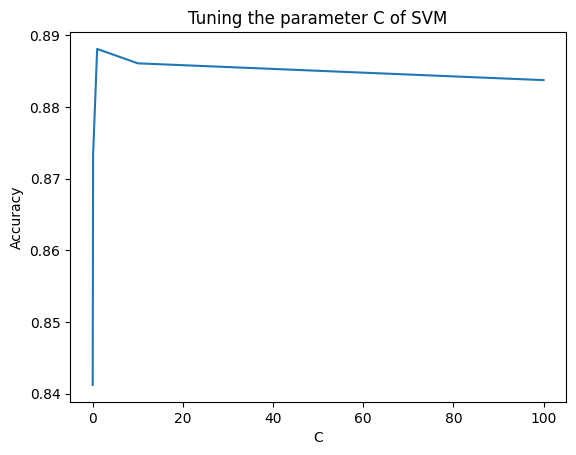

In [ ]:
c_values = [0.01, 0.1, 1, 10, 100]
accuracies = []

for C in c_values:
    SVC = LinearSVC(C=C)
    with warnings.catch_warnings(record=True) as w:
        warnings.filterwarnings("always", category=ConvergenceWarning)
        SVC.fit(X_train, y_train)


    if any(issubclass(warning.category, ConvergenceWarning) for warning in w):
            print(f"ConvergenceWarning déclenché pour C = {C}")
            SVC = LinearSVC(C=C, max_iter=10000)
            SVC.fit(X_train, y_train)
    accuracy = SVC.score(X_test, y_test)
    accuracies.append(accuracy)

#print('Accuracy = %f' % accuracy)
plt.plot(c_values, accuracies)
plt.title("Tuning the parameter C of SVM")
plt.xlabel("C")
plt.ylabel("Accuracy")
print("C optimal:", c_values[np.argmax(accuracies)])

C optimal: 2


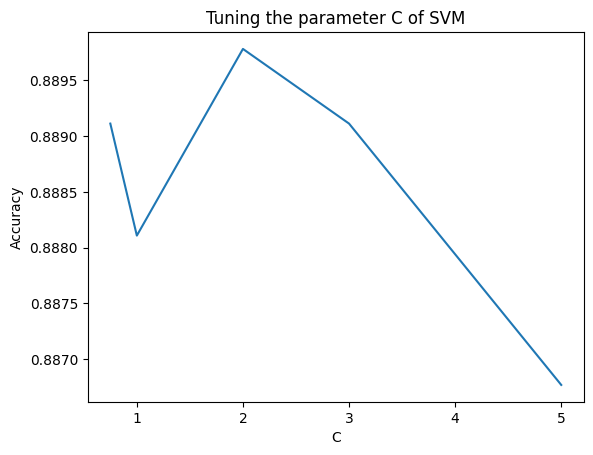

In [ ]:
c_values = [0.75, 1, 2, 3, 5]
accuracies = []

for C in c_values:
    SVC = LinearSVC(C=C)
    SVC.fit(X_train, y_train)

    accuracy = SVC.score(X_test, y_test)
    accuracies.append(accuracy)

#print('Accuracy = %f' % accuracy)
plt.plot(c_values, accuracies)
plt.title("Tuning the parameter C of SVM")
plt.xlabel("C")
plt.ylabel("Accuracy")
print("C optimal:", c_values[np.argmax(accuracies)])

La valeur optimale est C=2

## Replacing SVM with fully connected

In [ ]:
model = VGG16relu7(vgg16)
path = "15SceneData"
batch_size = 8

model.eval()
if CUDA: # si on fait du GPU, passage en CUDA
    cudnn.benchmark = True
    model = model.cuda()

# On récupère les données
print('Récupération des données')
train, test = get_dataset(batch_size, path)

# Extraction des features
print('Feature extraction')
X_train, y_train = extract_features(train, model)
X_test, y_test = extract_features(test, model)

Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


In [ ]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Créer des DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


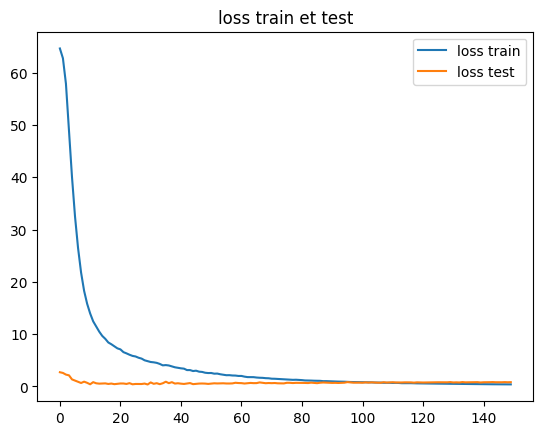

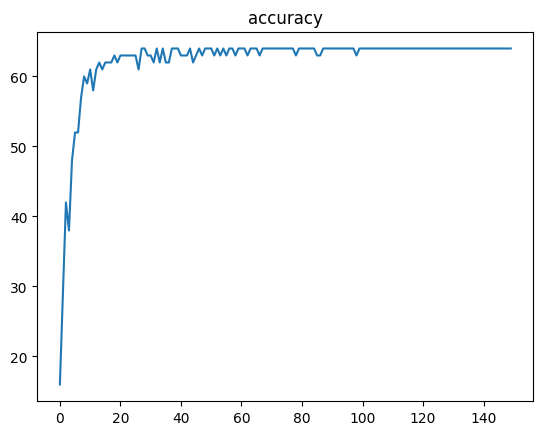

In [ ]:
# Création du classifieur
new_classifier = nn.Sequential(nn.Linear(4096, 1000), nn.ReLU(), nn.Linear(1000, 15))
new_classifier = new_classifier.cuda()

optim = torch.optim.SGD(new_classifier.parameters(), lr=0.5)
loss = nn.CrossEntropyLoss()
losses_train = []
losses_test = []
accuracies_test = []

nb_epochs = 150
for epoch in range(nb_epochs):
    loss_train_epoch = 0
    loss_test_epoch = 0
    accuracy_test_epoch = 0

    for input, target in train_loader:
        if CUDA:
            input = input.cuda()
            target = target.cuda()
        y_hat = new_classifier(input)
        loss_value = loss(y_hat, target)
        optim.zero_grad()
        loss_value.backward()
        optim.step()

        loss_train_epoch += loss_value

    losses_train.append(loss_train_epoch.cpu().detach().numpy())

    for input, target in test_loader:
        if CUDA:
            input = input.cuda()
            target = target.cuda()
        with torch.no_grad():
            y_hat = new_classifier(input)
            loss_value = loss(y_hat, target)
        loss_test_epoch += loss_value
        accuracy_test_epoch += torch.sum(torch.argmax(y_hat, dim=1)==target)
    losses_test.append(loss_value.cpu().detach().numpy())
    accuracies_test.append(accuracy_test_epoch.cpu().detach().numpy()//len(target))

plt.plot(np.arange(len(losses_train)), losses_train, label="loss train")
plt.plot(np.arange(len(losses_test)), losses_test, label="loss test")
plt.legend()
plt.title("loss train et test")
plt.show()
plt.plot(np.arange(len(accuracies_test)), accuracies_test, label="accuracy test")
plt.title('accuracy')
plt.show()